#  Four exercises for understanding echoes and reverberations

<a href="https://juanfonsecasolis.github.io/">Juan M. Fonseca-Solís</a> · June 2020 (last updated on June 2025) · 7 min read

---

_"Sabéis, en efecto, amadísimos, que la palabra, cuando toma la voz como su auxiliar y pasa por el sendero del oído a la región de la mente, esa palabra crece en la mente, la vox fenece en el oído. Efectivamente, el sonido que ha golpeado al oído no permanece, (pero sí la palabra) porque ha descendido a la mente ¿Por qué esto? Porque conviene que él crezca y yo, en cambio, mengüe."_ - San Agustín, Sermón 293B.<sup>1</sup>

---

## Summary 
After hitting a solid structure, the sound produced by a speaker can bounce back to him from a single direction (echoes) or multiple directions (reverberations); an example of the former is shouting at a distant formation (like a cliff), and an example of the latter is shouting inside a stadium or a cathedrals [3].

If instead of shouting, you produce a transient and sharp noise (like the bursting of a balloon) and record the audio until it fades away, you can fully characterize the acoustics of the room (the recording is called [_room-impulse response_](https://nbviewer.jupyter.org/github/LCAV/SignalsOfTheDay/blob/master/Room_Acoustics/Room%20Impulse%20Response.ipynb) or RIR, for short). It is possible to use the RIR to perform inverse engineering and emulate how audio will sound inside that room using a technique called [auralization](https://en.wikipedia.org/wiki/Auralization). In auralization, you "filter" the audio with the RIR with the help of a mathematical operation called _convolution_. You can also use a synthetic RIR, and simulate a virtual space.

In this iPython notebook, we use an RIR proposed in the book _Digital Signal Processing: Principles, Algorithms and Applications_ by J. Proakis and D. Manolakis [1] to filter an audio signal recorded by us and solve some exercises provided by the book. 

### The audio
Let's start with the audio we will filter and the place where it was recorded. It's a dry sound recorded directly from the microphone of the left ambon of San Josecito's temple at San Isidro of Heredia, Costa Rica. The recording was taken from a transmission streamed by the church on its Facebook page during the COVID-19 pandemic.

In [1]:
from scipy.io import wavfile
from IPython.display import Audio

fs_org, x_org = wavfile.read('./wav/highquality_100520.wav')
Audio(x_org, rate=fs_org) 

C:\Users\juanf\AppData\Local\Temp\ipykernel_1192\2402845596.py:4: WavFileWarning: Chunk (non-data) not understood, skipping it.
  fs_org, x_org = wavfile.read('./wav/highquality_100520.wav')


![San Josecito's temple arranged for the Pentecost celebration. San José, San Isidro of Heredia, Costa Rica. - 2025 Juan M. Fonseca-Solís](img/templo-sanJosecito.jpg)

# The three exercises

Below are the exercises proposed by J. Proakis, D. Manolakis, and the respective RIRs (written as transfer functions):

![](img/echoCancellation3.png)
![](img/echoCancellation4.png)

And now, let's go with the solutions.

## Exercise A (creating echoes)

To get the impulse response for this exercise, we need to apply the inverse [Z transform](https://es.wikipedia.org/wiki/Transformada_Z) to the provided transfer function, which gives the following difference equation:

$$
y[n] = x[n] - \alpha y[n-D].
$$

To plot the impulse response, we can take an arbitrary support of 50 points and set the parameters to $\alpha=0.7$ and $D=5$:

<StemContainer object of 3 artists>

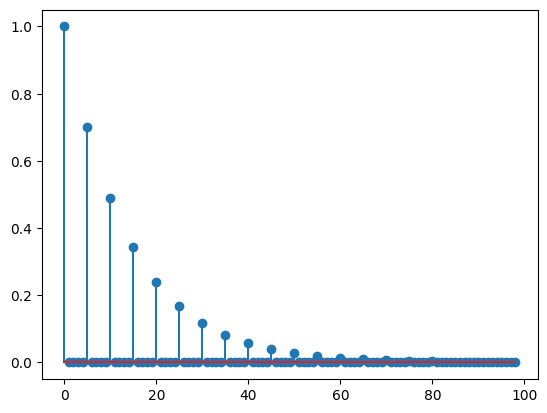

In [2]:
import matplotlib.pyplot as plt
import numpy as np

def comb(x, alpha, D):
    N = len(x)
    y = np.zeros(N)
    for n in range(0,N):
        y[n] = x[n] + alpha*(0 if n-D<0 else y[n-D]) # using positive gain for removal purposes
    return y
        
kronecker = np.zeros(99)
kronecker[0] = 1
    
plt.stem(np.abs(comb(kronecker, alpha=0.7, D=5)))

We observe that, in effect, the impulse response of the comb filter is a function that decays exponentially (repetitions get softer, not louder, as in St. Augustine's fragment sermon above). Let's filter our recording, simulating that the sound bounces back from a single wall located at 100 meters:

In [3]:
distance = 100 # m
speed_of_sound = 380 # m/s
y_a = comb(x_org, alpha=0.5, D=int((distance/speed_of_sound)*fs_org))
Audio(y_a, rate=fs_org) 

As you can hear, the recording contains echoes (remember that echoes are clearer than reverberations), which indicates that the comb filter is suitable for this task. We can even plot the absolute value of the [autocorrelation](https://en.wikipedia.org/wiki/Autocorrelation) to calculate the reverberation delay. The echoes in the autocorrelation plot are visualized as peaks.

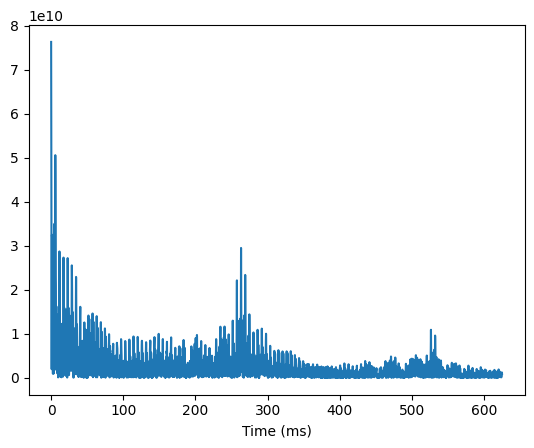

In [4]:
def plotAutocorr(x,fs):
    r = np.correlate(x,x,'same')
    r = r[int(len(r)/2):-1] # the correlation is simetric, so we can discard the first half
    t = 1000*np.linspace(0,(len(r)+0.0)/fs,len(r)) # plot in milliseconds
    plt.plot(t,np.abs(r))
    plt.xlabel('Time (ms)')
    
plotAutocorr(y_a[0:10000],fs_org)

As we can see above, the echo delay is approximately 102.6 meters (270 ms), which is close to the 100 meters we specified above. Instead of using the difference equation, we could have applied the convolution of the comb difference equation and the audio to get the same result:

$$
(x*y)[t] = \int_{-\infty}^{\infty}{x[T]y[T-t]dT}
$$

---

_"Cristo es la Palabra, Juan la voz, puesto que está escrito de aquél: En el principio existía la Palabra. Juan, en cambio, hablando de sí mismo, dice: Yo soy la voz del que clama en el desierto."_ - San Agustín, Sermón 293B.<sup>1</sup>

---

## Exercise B (creating reverberations) 

On this exercise, we got a new transfer function, so we proceed to repeat the same procedure as Exercise A. The difference equation is now:

$$
y[n] = -\alpha x[n] + x[n-D] + \alpha y[n-D],
$$

and by reusing the same parameters $\alpha$ and $D$, the impulse response would look like this:

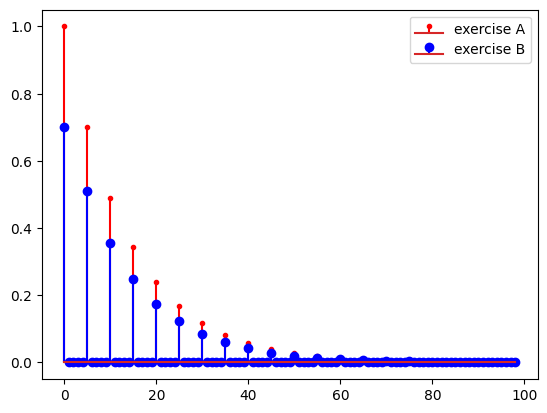

In [5]:
def allpasscomb(x, alpha, D):
    N = len(x)
    y = np.zeros(N)
    for n in range(0,N):
        y[n] = -alpha*x[n] + (0 if n-D<0 else x[n-D]) + alpha*(0 if n-D<0 else y[n-D])
    return y
        
plt.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', label='exercise A')
plt.stem(np.abs(allpasscomb(kronecker,alpha=0.7,D=5)), linefmt='blue', label='exercise B')
plt.legend()

The blue curve on the figure represents the new impulse response, while the red one is the old one. We see that both are identical, except that the second one is shifted one unit to the left. Now, if we put multiple all-pass filters in cascade and set up the parameters as in unit 1, the impulse response would look like this:

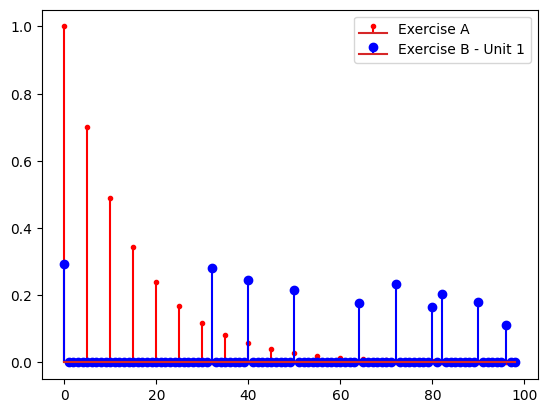

In [6]:
def cascade(x, alphas, Ds):
    y = x
    for i in range(0,len(alphas)):
        y = allpasscomb(y,alphas[i],Ds[i])
    return y

plt.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', label='Exercise A')
plt.stem(np.abs(cascade(kronecker, [0.7,0.665,0.63175], [50,40,32])), linefmt='blue', label='Exercise B - Unit 1')
plt.legend()

We notice that the exponential decay shape has been lost and that the impulses are not aligned. Also, there is a region between 0 and 30 samples that is empty. How does it sound?

In [7]:
y_b = cascade(x_org, [0.7,0.665,0.63175], np.multiply(15, [50,40,32])) # escalamos los retrasos para escucharlos
Audio(y_b, rate=fs_org) 

As you can hear, the audio replicas are not so clear, which happens in reverberations (by definition, echoes are easier to listen to). Now let's plot the impulse response with the parameters of unit 2:

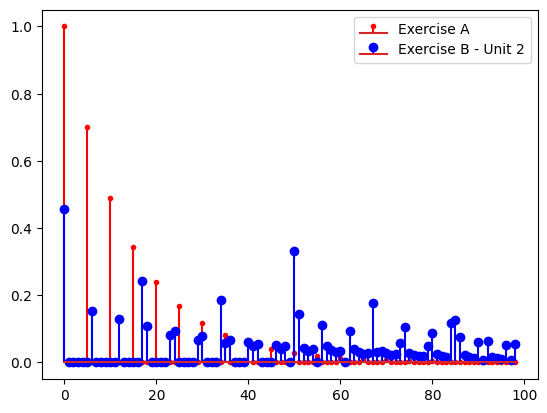

In [8]:
plt.stem(np.abs(comb(kronecker, alpha=0.7, D=5)), linefmt='red', markerfmt='.', label='Exercise A')
plt.stem(np.abs(cascade(kronecker, [0.7,0.77,0.847], [50,17,6])), linefmt='blue', label='Exercise B - Unit 2')
plt.legend()

Alright, now we observe that the impulses are better unaligned than in unit 1, but the exponential shape is not always preserved. Once again, let's use it to process the recording:

In [9]:
y_b = cascade(x_org, [0.7,0.77,0.847], np.multiply(15, [50,17,6])) # escalamos los retrasos para escucharlos
Audio(y_b, rate=fs_org) 

As you can hear, although the audio does not have the same quality as Exercise A, it is clear enough almost to the end.

## Exercise C (choosing the best reverberator)

At this point, we can answer the question in Exercise C. Unit 1 is a better reverberator because it doesn't produce clear repetitions of the signal, and the reason might be that delays are 32 samples long (which is the shortest delay in Unit 1). This corresponds to a delay in time of:

In [10]:
T_u1_min = (32.0/fs_org)*1000;
T_u2_min = (6.0/fs_org)*1000;
print('%.2f ms (Unit 1) vs %.2f ms (Unit 2)' % (T_u1_min, T_u2_min))

4.00 ms (Unit 1) vs 0.75 ms (Unit 2)


## One more exercise (not in the book)

The echoes added by the transfer function of Exercise A can be reverted using its inverse: $H^{-1}(z) = 1 - \alpha z^{-D}$, as explained by Prandoni et al. [2]. The respective difference function is $z[n] = y[n] - \alpha y[n-D]$.

In [11]:
def inverseComb(x, alpha, D):
    N = len(x)
    y = np.zeros(N)
    for n in range(0,N):
        y[n] = x[n] - alpha*(0 if n-D<0 else x[n-D])
    return y

z = inverseComb(y_a, alpha=0.5, D=int((distance/380)*fs_org))
Audio(z, rate=fs_org) 

As you can hear, the echoes have been completely removed, and the sound is now dry. This method works because we had the transfer function by forehand, in practice, this doesn't happen, and reverberations need to be removed using [more advanced techniques](https://en.wikipedia.org/wiki/Echo_suppression_and_cancellation).

# Notes
1. Translation by José Anoz Gutierrez (birth of John the Baptist). Text cited by Father Farid in San Isidro's temple at San Isidro de Heredia, Costa Rica.

# References

1. J. Proakis, D. Manolakis. Digital Signal Processing: Principles, Algorithms and Applications, 3rd Edition. Peason.
2. P. Prandoni, M. Vetterli, I. Dokmanic. Lesson 4.12: Dereverberation and echo cancellation. Digital signal processing. LCAV-EPFL at Coursera. URL: https://www.coursera.org/learn/dsp
3. R. Pryn. Echo Vs Reverb - What's The Difference? September 2022. URL: https://richardpryn.com/echo-vs-reverb-whats-the-difference/ (last consulted on 11/03/24)